# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2025-LGElec-Day22.git ### colab 사용 시

' github 연동 '

## **2. About Jupyter Notebook**

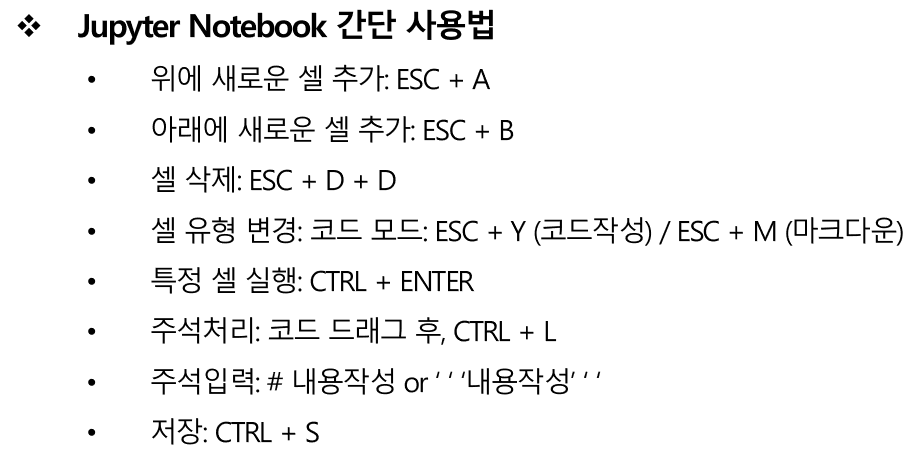

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - ***(2) Data Balancing (2) - Oversampling √***

 - (3) XAI

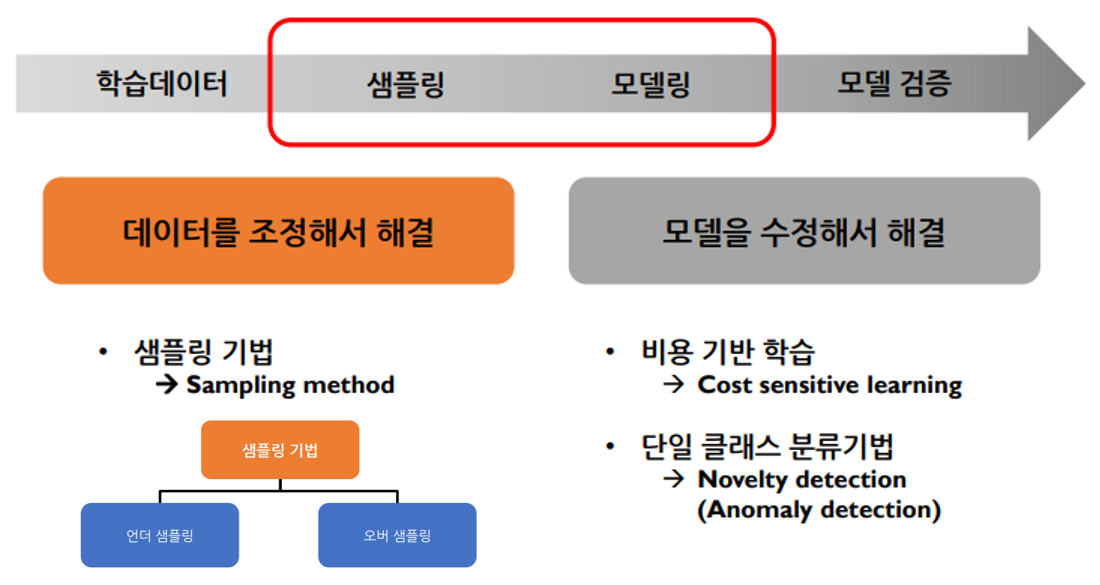

In [3]:
""" 설명 장표 불러오기 """
Image('image/3-DataBalancing1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/3-DataBalancing1.PNG') ### colab 사용 시

## **[Data Balancing - OverSampling 목차]**

  - Resampling

  - SMOTE

  - Borderline-SMOTE

  - ADASYN

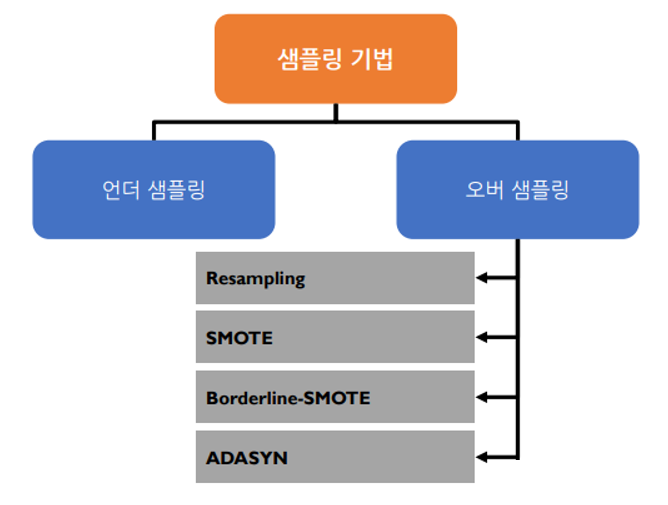

In [4]:
""" 설명 장표 불러오기 """
Image('image/5-OverSampling1.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/5-OverSampling1.PNG') ### colab 사용 시

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [5]:
""" 필요 패키지 설치 """
!pip install imblearn

In [6]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import itertools
import numpy as np
import pandas as pd


""" 모델링 및 성능 산출과 관련된 패키지"""
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


""" 데이터 샘플링 패키지 """
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN


""" 데이터 시각화 패키지 """
import seaborn as sns
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

#### **0-2. 필요 함수 사전 정의**

In [7]:
""" (1) Sampling 전 후 데이터 분포를 시각화하여 분석하는 함수 (for Binary Classification) """

def plot_binary_representation(X, y, X_syn, y_syn, title1, title2):
    
    fig = plt.figure(figsize=(16, 8))
    
    ### (1) 기존 데이터 시각화
    ax1 = fig.add_subplot(1, 2, 1) ### 그림 그릴 위치 지정
    y_normal, y_anomaly = y[y==0].dropna(), y[y==1].dropna() ### 기존 정상 데이터, 이상 데이터 추출 (X, y) --> y=0: 정상 / y=1 비정상
    X_normal, X_anomaly = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly.index), :]

    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal') ### 정상 데이터 시각화
    ax1.scatter(X_anomaly['X1'], X_anomaly['X2'], alpha=0.3, c='red', label='Anomaly') ### 이상 데이터 시각화
    
    ax1.spines['top'].set_visible(False) ### 그림의 위쪽 테두리 지우기
    ax1.spines['right'].set_visible(False) 
    plt.xlim((-5, 5)) ### x축 범위 지정
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title(title1, fontsize=20)

    ### (2) Sampling 된 데이터 시각화 (X_syn, y_syn)
    ax2 = fig.add_subplot(1, 2, 2)
    y_syn_normal, y_syn_anomaly = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna()
    X_syn_normal, X_syn_anomaly = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly.index), :]

    ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax2.scatter(X_syn_anomaly['X1'], X_syn_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title(title2, fontsize=20)
        
    plt.show()

In [8]:
""" (2) Confusion Matrix를 시각화하는 함수 """

def plot_confusion_matrix(confusion_matrix, classes):

    ### Confusion Matrix 시각화
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    ### X축 및 Y축 눈금에 Class 표시
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    ### Confusion Matrix 숫자 기입
    thresh = confusion_matrix.max() / 2. ### 폰트 색상 지정을 위한 Threshold
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), ### 숫자 작성
                 horizontalalignment="center", ### 숫자를 각 행렬 가운데 작성
                 color="white" if confusion_matrix[i, j] > thresh else "black") ### Threshold에 따라 글자 색상 다르게 지정

    ### X축 및 Y축 레이블 표기
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ### 이미지 크기 최적화 및 시각화
    plt.tight_layout()
    plt.show()

In [9]:
""" (3) 성능 평가 Metric을 산출하는 함수 """

"""
macro: Class 불균형을 고려한 성능지표
"""

def calculate_classification_metrics(true_labels, predicted_labels):
    
    ### 성능지표 산출
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    ### Log
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

In [10]:
""" (4) 실습 데이터셋을 생성하는 함수 """
def create_dataset(n_samples=2000, n_classes=2, weights=(0.8, 0.2), n_cluster=1, class_sep=1, random_state=2025):
    
    ### 데이터셋 생성
    df = make_classification(n_samples=n_samples, ### Instance 개수
                                n_features=2, ### 변수 개수
                                n_redundant=0, ### 선형결합으로 생성 가능한 겹치는 변수 개수
                                n_classes=n_classes, ### Class 개수
                                weights=list(weights), ### 클래스 비율
                                n_clusters_per_class=n_cluster, ### Class 당 군집 개수
                                class_sep=class_sep, ### 클래스 군집 간 간격 (클수록 멀어짐)
                                random_state=random_state)
    
    ### X, y 구분
    X = pd.DataFrame(df[0], columns=['X1', 'X2'])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

## **1. Binary Classification**

#### **1-1. 실습 데이터 생성**
 - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [11]:
""" 데이터 생성 """
X_syn, y_syn = create_dataset(n_samples=5000,
                               n_classes=2, 
                               weights=(0.9, 0.1), 
                               n_cluster=1, 
                               class_sep=1, 
                               random_state=2025)

print(X_syn.shape, y_syn.shape)

(5000, 2) (5000, 1)


In [12]:
""" 데이터 형태 확인 """
pd.concat((X_syn, y_syn),axis=1)

,X1,X2,y
0,-0.531085,1.105561,0
1,-1.337406,1.832934,0
2,-0.661052,-0.289082,0
3,-0.845163,0.659521,0
4,-1.137641,0.484028,0
...,...,...,...
4995,-1.423838,1.201032,0
4996,-0.702077,0.952859,0
4997,-0.603809,1.530758,0
4998,-0.725557,1.198236,0


In [13]:
""" 데이터 불균형 확인 """
print(y_syn.value_counts())

y
0    4475
1     525
Name: count, dtype: int64


In [14]:
""" Train/Test 분할 """
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, random_state=2025)

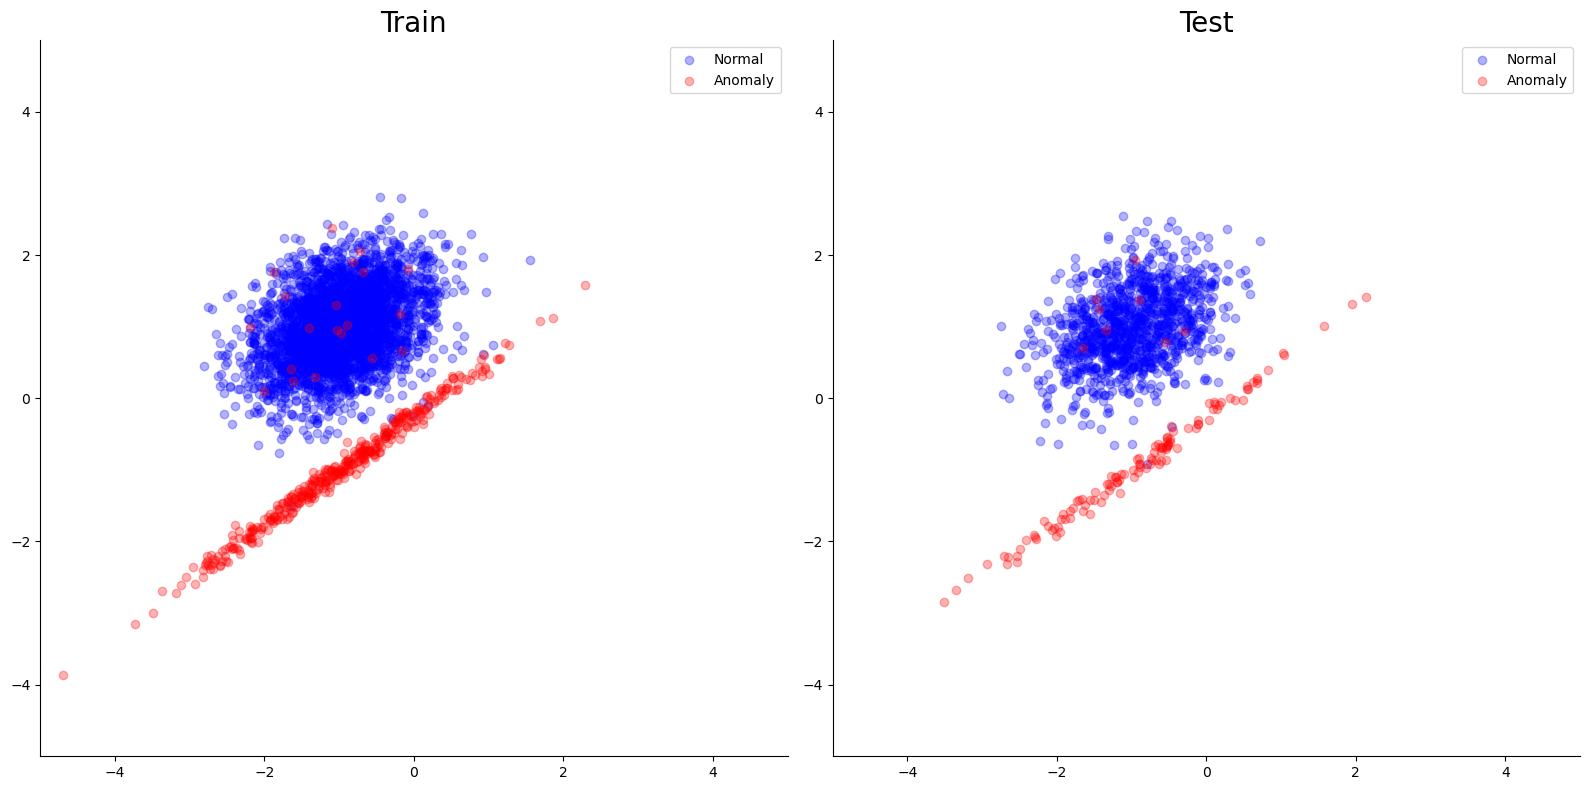

In [15]:
""" 데이터 분포 시각화 """
plot_binary_representation(X_train, 
                        y_train, 
                        X_test, 
                        y_test, 
                        title1='Train', 
                        title2='Test')

#### **1-2. 데이터가 불균형한 상태에서 모델링 (Baseline)**

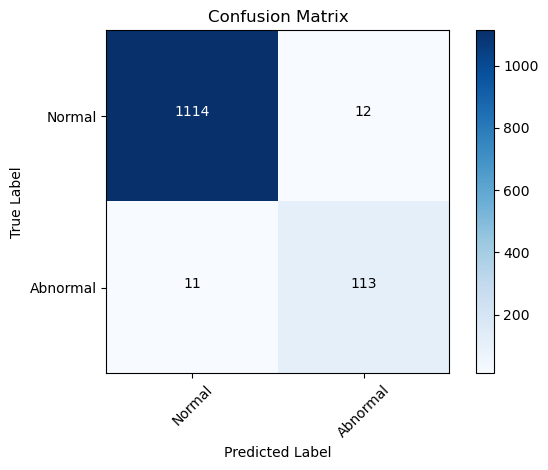

Accuracy : 0.9816
Precision : 0.9471
Recall : 0.9503
F1-score : 0.9487


In [16]:
""" 데이터 불균형한 상태에서 모델링 후, 모델 성능 파악 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2025)
dt_tree.fit(X_train, y_train)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

#### **1-3. Resampling 적용**

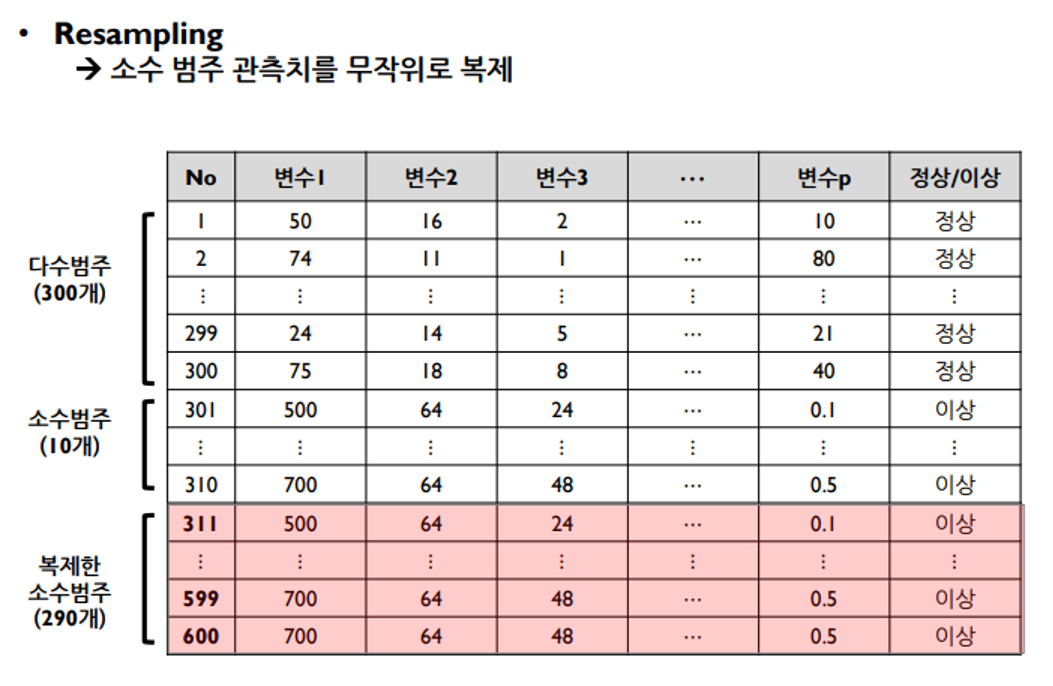

In [17]:
""" 설명 장표 불러오기 """
Image('image/5-OverSampling2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/5-OverSampling2.PNG') ### colab 사용 시

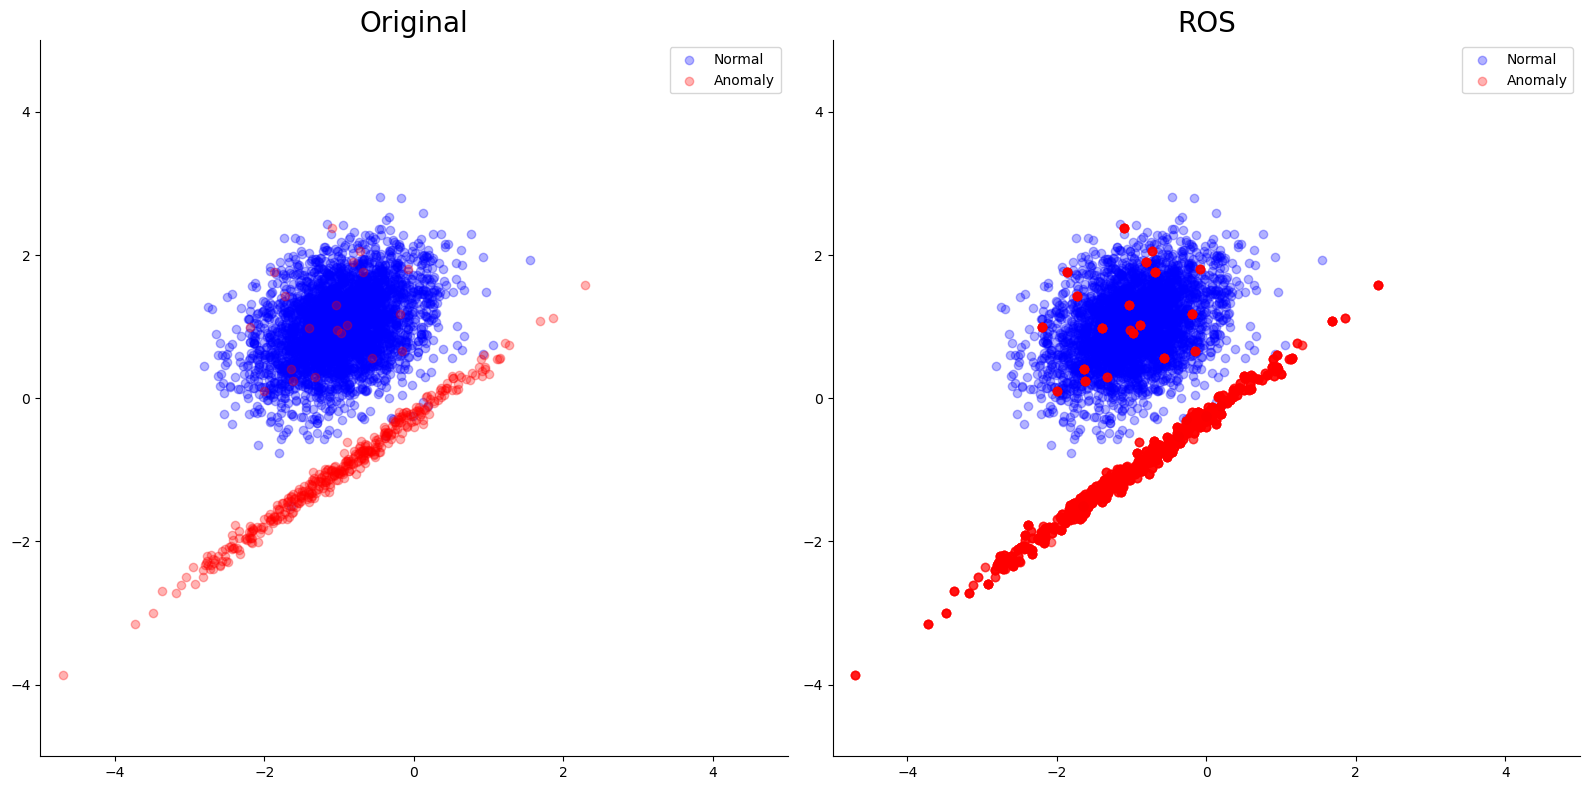

In [18]:
""" Resampling 적용 """

### Random OverSampling 수행
ros = RandomOverSampler(random_state=2025) 
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

### 데이터 분포 시각화
plot_binary_representation(X_train, 
                           y_train, 
                           X_resampled, 
                           y_resampled, 
                           title1='Original',
                           title2='ROS')

In [19]:
""" Random OverSampling 결과 확인 """
print('======== Before ========')
print(y_train.value_counts().sort_index())
print()
print('======== After ========')
print(y_resampled.value_counts().sort_index())

======== Before ========
y
0    3349
1     401
Name: count, dtype: int64

======== After ========
y
0    3349
1    3349
Name: count, dtype: int64


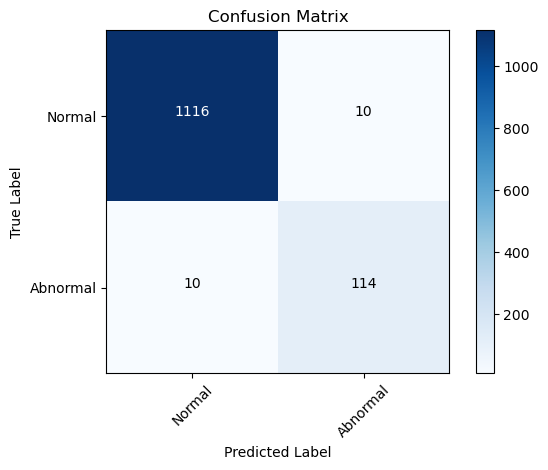

Accuracy : 0.9840
Precision : 0.9552
Recall : 0.9552
F1-score : 0.9552


In [20]:
""" Resampling 적용 후, 모델 성능 파악 """

### 모델 Train & Test
ros_tree = tree.DecisionTreeClassifier(random_state=2025)
ros_tree = ros_tree.fit(X_resampled, y_resampled)
y_pred_test = ros_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_ros = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_ros, classes)
_, _, _, f1_ros = calculate_classification_metrics(y_test, y_pred_test)

#### **1-4. SMOTE 적용**

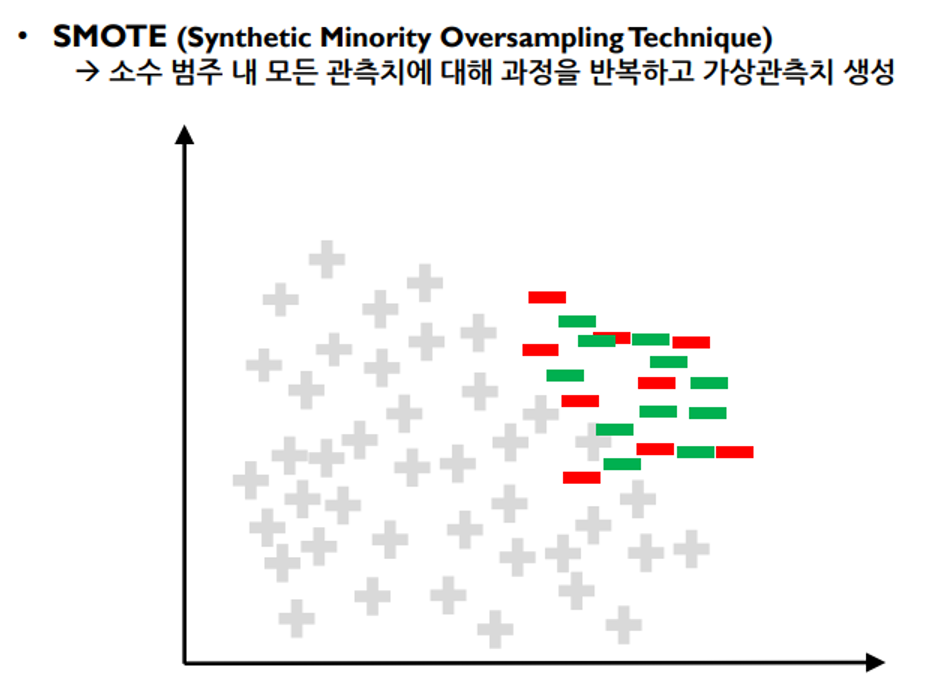

In [21]:
""" 설명 장표 불러오기 """
Image('image/5-OverSampling3.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/5-OverSampling3.PNG') ### colab 사용 시

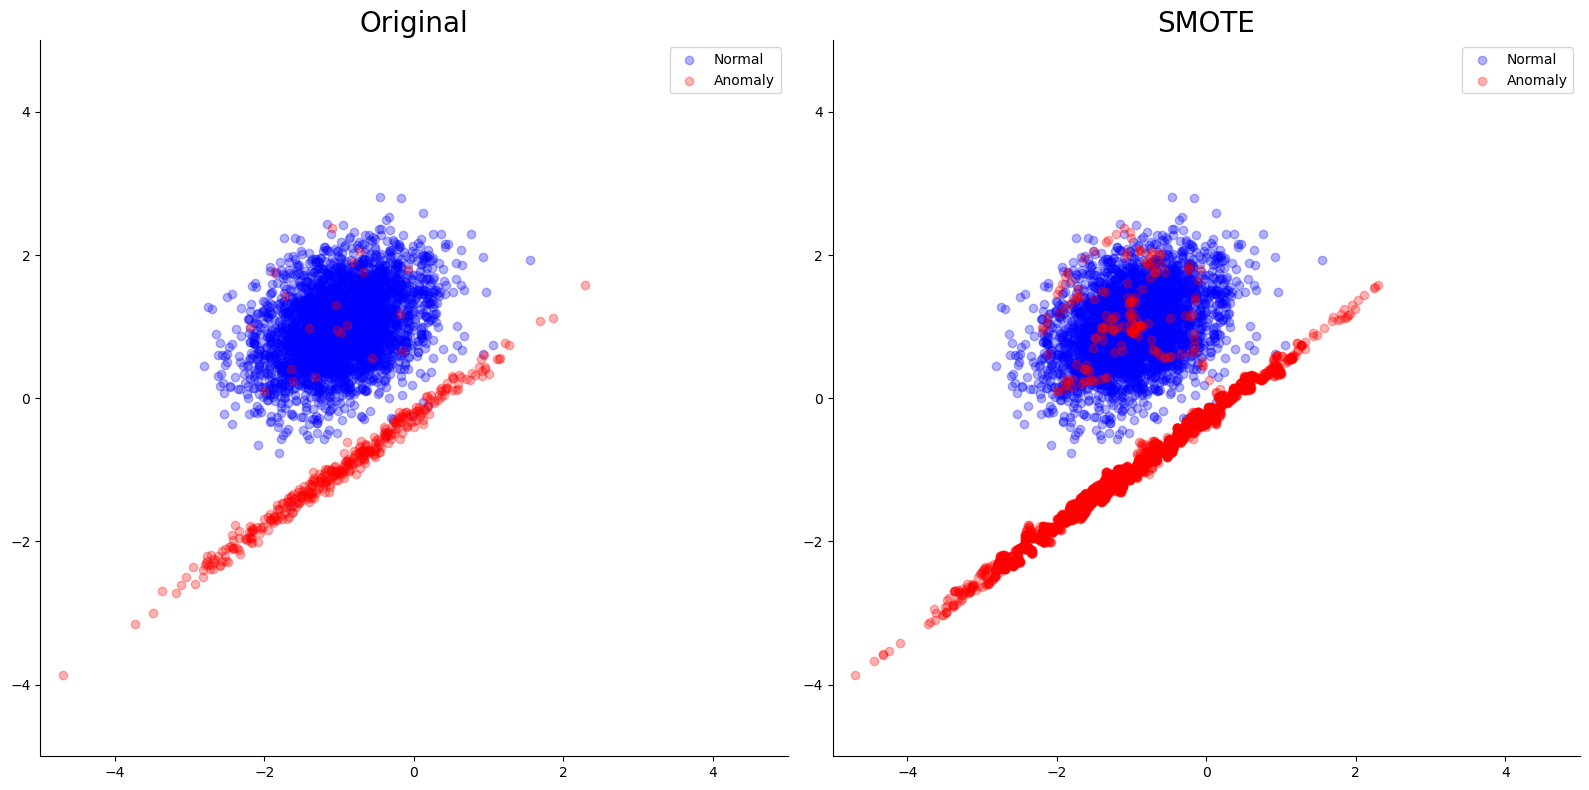

In [22]:
""" SMOTE 적용 """

### SMOTE 수행
smote = SMOTE(random_state=2025,
              k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### 데이터 분포 시각화
plot_binary_representation(X_train, 
                           y_train, 
                           X_resampled, 
                           y_resampled, 
                           title1='Original',
                           title2='SMOTE')

In [23]:
""" SMOTE 결과 확인 """
print('======== Before ========')
print(y_train.value_counts().sort_index())
print()
print('======== After ========')
print(y_resampled.value_counts().sort_index())

======== Before ========
y
0    3349
1     401
Name: count, dtype: int64

======== After ========
y
0    3349
1    3349
Name: count, dtype: int64


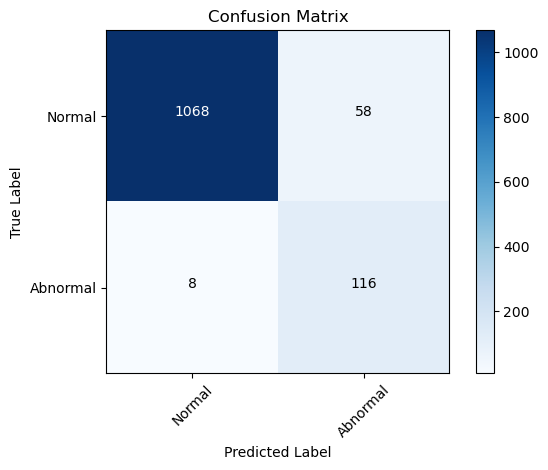

Accuracy : 0.9472
Precision : 0.8296
Recall : 0.9420
F1-score : 0.8743


In [24]:
""" SMOTE 적용 후, 모델 성능 파악 """

### 모델 Train & Test
smote_tree = tree.DecisionTreeClassifier(random_state=2025)
smote_tree = smote_tree.fit(X_resampled, y_resampled)
y_pred_test = smote_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_smote = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_smote, classes)
_, _, _, f1_smote = calculate_classification_metrics(y_test, y_pred_test)

#### **1-5. Borderline-SMOTE 적용**

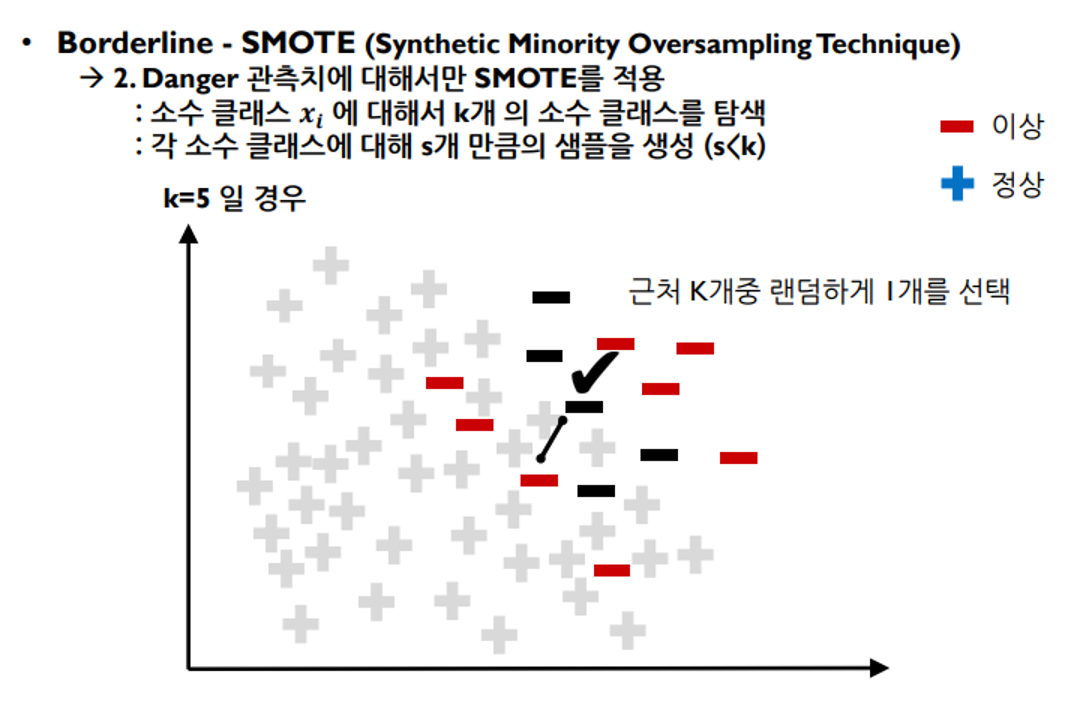

In [25]:
""" 설명 장표 불러오기 """
Image('image/5-OverSampling4.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/5-OverSampling4.PNG') ### colab 사용 시

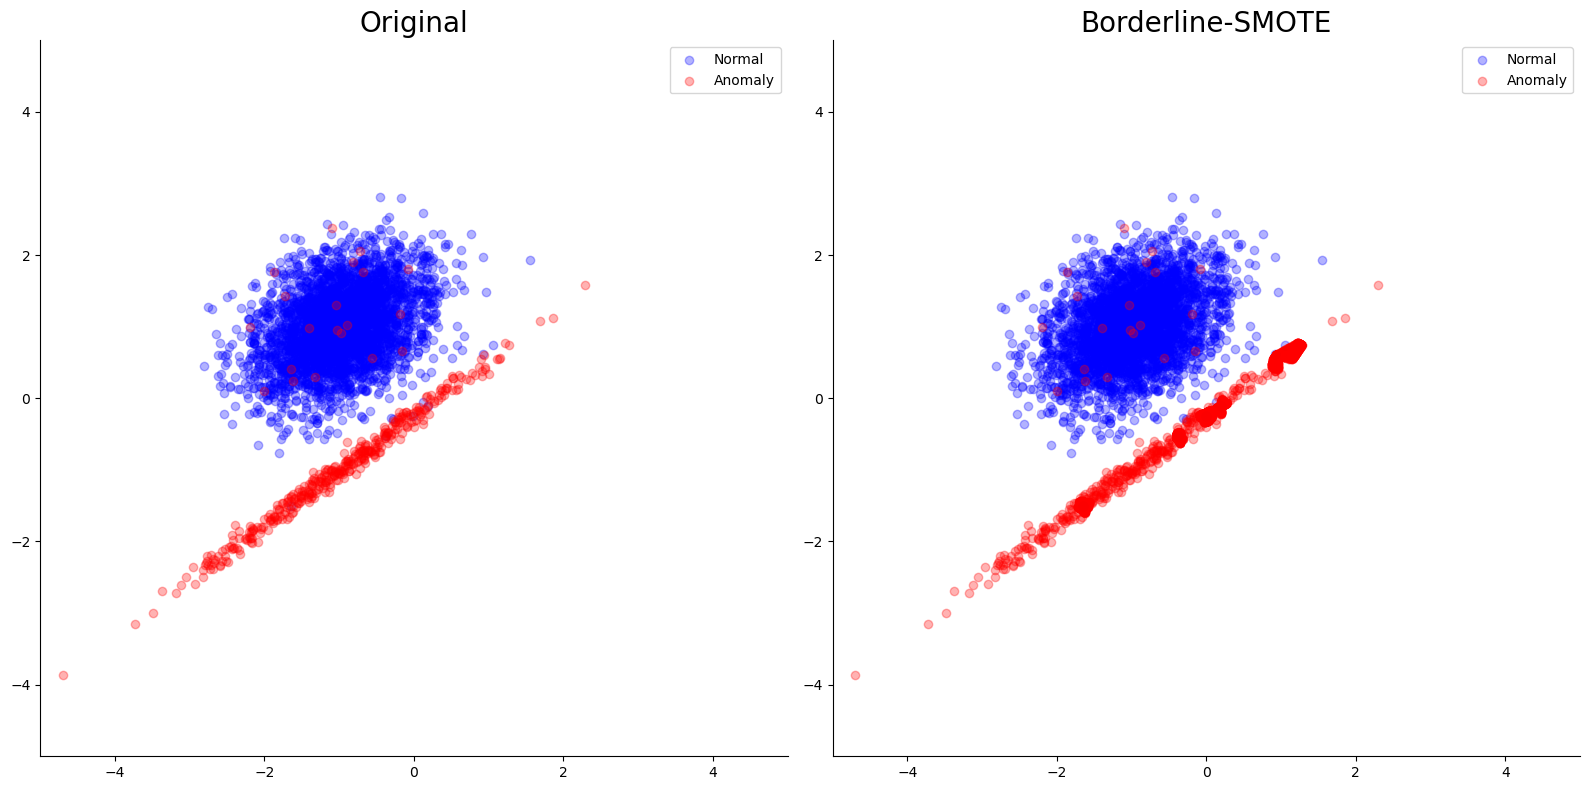

In [26]:
""" Borderline-SMOTE 적용 """

### Borderline-SMOTE 수행
bl_smote = BorderlineSMOTE(random_state=2025,
                           k_neighbors=5,
                           m_neighbors=2) ### Danger 관측치 기준
X_resampled, y_resampled = bl_smote.fit_resample(X_train, y_train)

### 데이터 분포 시각화
plot_binary_representation(X_train, 
                           y_train, 
                           X_resampled, 
                           y_resampled, 
                           title1='Original',
                           title2='Borderline-SMOTE')

In [27]:
""" Borderline-SMOTE 결과 확인 """
print('======== Before ========')
print(y_train.value_counts().sort_index())
print()
print('======== After ========')
print(y_resampled.value_counts().sort_index())

======== Before ========
y
0    3349
1     401
Name: count, dtype: int64

======== After ========
y
0    3349
1    3349
Name: count, dtype: int64


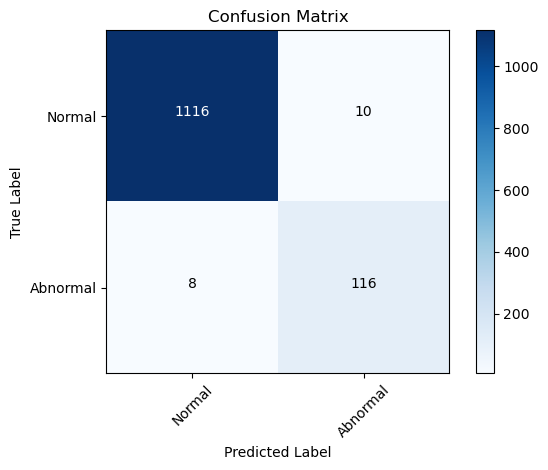

Accuracy : 0.9856
Precision : 0.9568
Recall : 0.9633
F1-score : 0.9600


In [28]:
""" Borderline-SMOTE 적용 후, 모델 성능 파악 """

### 모델 Train & Test
blsmote_tree = tree.DecisionTreeClassifier(random_state=2025)
blsmote_tree = blsmote_tree.fit(X_resampled, y_resampled)
y_pred_test = blsmote_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_blsmote = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_blsmote, classes)
_, _, _, f1_blsmote = calculate_classification_metrics(y_test, y_pred_test)

#### **1-6. ADASYN 적용**

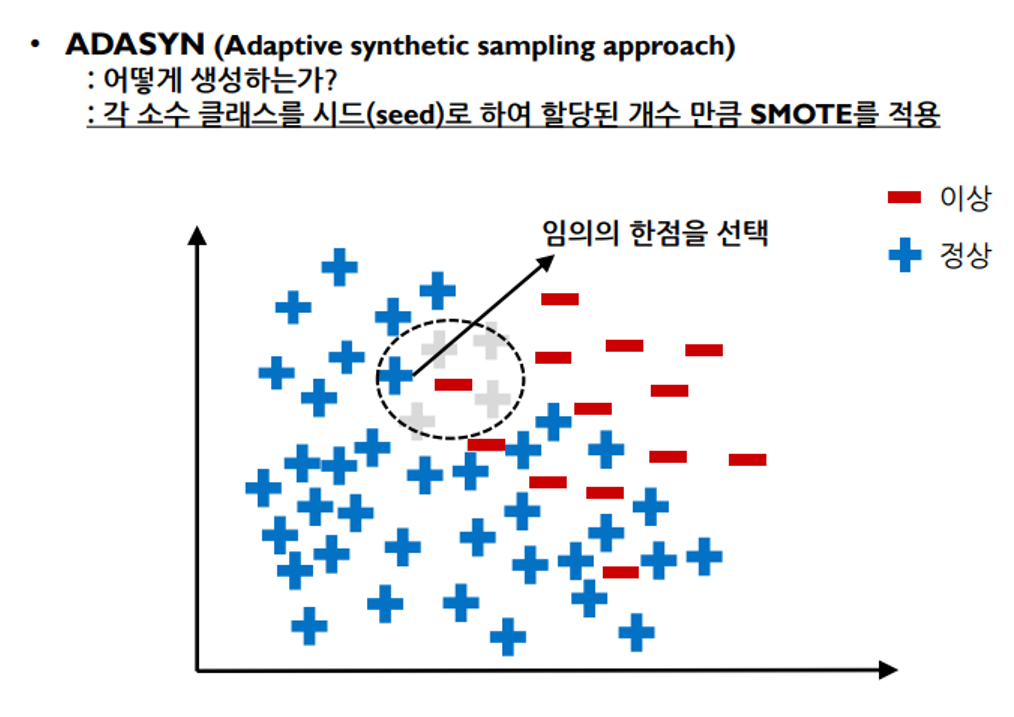

In [29]:
""" 설명 장표 불러오기 """
Image('image/5-OverSampling5.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/5-OverSampling5.PNG') ### colab 사용 시

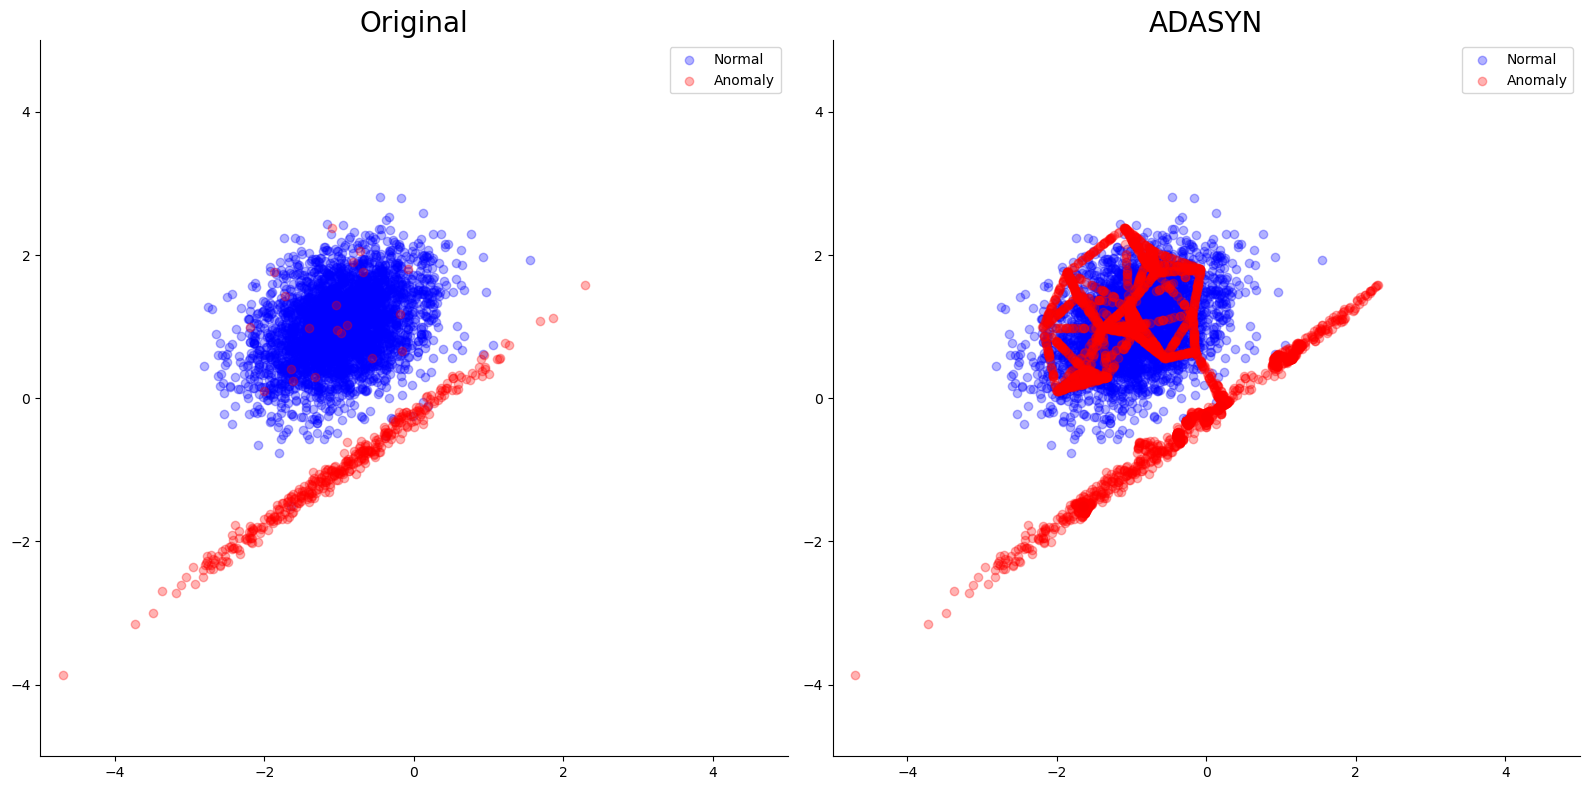

In [30]:
""" ADASYN 적용 """

### ADASYN 수행
adasyn = ADASYN(random_state=2025,
                n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

### 데이터 분포 시각화
plot_binary_representation(X_train, 
                           y_train, 
                           X_resampled, 
                           y_resampled, 
                           title1='Original',
                           title2='ADASYN')

In [31]:
""" ADASYN 결과 확인 """
print('======== Before ========')
print(y_train.value_counts().sort_index())
print()
print('======== After ========')
print(y_resampled.value_counts().sort_index())

======== Before ========
y
0    3349
1     401
Name: count, dtype: int64

======== After ========
y
0    3349
1    3359
Name: count, dtype: int64


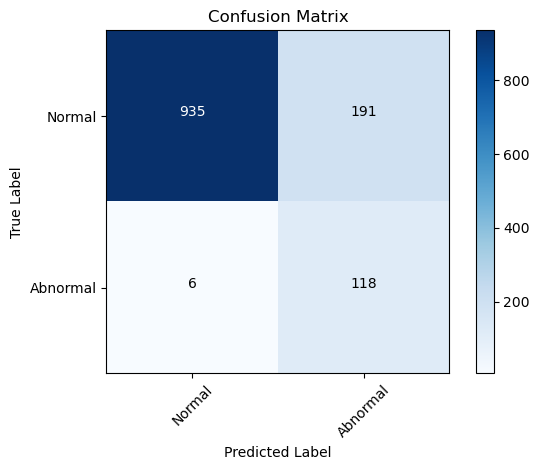

Accuracy : 0.8424
Precision : 0.6878
Recall : 0.8910
F1-score : 0.7249


In [32]:
""" ADASYN 적용 후, 모델 성능 파악 """

### 모델 Train & Test
adasyn_tree = tree.DecisionTreeClassifier(random_state=2023)
adasyn_tree = adasyn_tree.fit(X_resampled, y_resampled)
y_pred_test = adasyn_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_adasyn = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_adasyn, classes)
_, _, _, f1_adasyn = calculate_classification_metrics(y_test, y_pred_test)

#### **1-7. 알고리즘 별 성능 비교**

<Axes: >

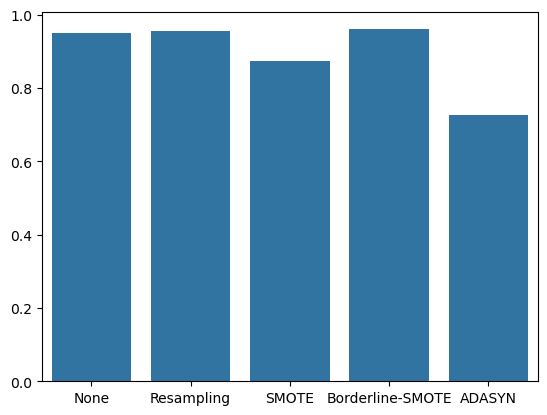

In [33]:
""" 알고리즘 별 성능 비교 """
sns.barplot(x=['None', 'Resampling', 'SMOTE', 'Borderline-SMOTE', 'ADASYN'],
            y=[f1_baseline, f1_ros, f1_smote, f1_blsmote, f1_adasyn])